In [1]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions
from vpsto.obf import OBF
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%load_ext autoreload
%autoreload 2

In [2]:
save_figures = False # set to True to save figures

In [3]:
# A class containing the forward kinematics for the 2D manipulator
class Manipulator():
    def __init__(self):
        self.l = np.array([1, 1]) # link lengths
        self.q_min = np.array([0., -np.pi])
        self.q_max = np.array([np.pi, 0.])

    # Define the forward kinematics of the manipulator
    def fk(self, q):
        # q: 2x1 array of joint angles
        # Returns: 2x1 array of end-effector position
        x0 = np.zeros(2)
        x1 = x0 + self.l[0] * np.array([np.cos(q[0]), np.sin(q[0])])
        x2 = x1 + self.l[1] * np.array([np.cos(q[0] + q[1]), np.sin(q[0] + q[1])])
        return np.vstack((x0, x1, x2))

In [4]:
# Collision environment including spherical obstacle and walls
class CollisionEnvironment():
    def __init__(self):
        self.x = np.array([0.5, 0.5])
        self.r = 0.1
        self.r_sq = self.r**2

        self.x_min = np.array([-0.75, 0.])
        self.x_max = np.array([1.5, 1.5])
        
    def isTrajectoryCollision(self, pts):
        # pts: (k, n, 2) array. Each matrix is the kinematic chain. Each row is a 2D point along the kinematic chain of the robot
        # Check if the robot pts along the trajectory intersect with the spherical obstacle
        # return an array of k elements, each element is a boolean indicating if the robot is in collision at that time step
        pts_ = np.empty((pts.shape[0] * (pts.shape[1]-1), 4))
        pts_[:,:2] = pts[:,:-1].reshape(-1, 2)
        pts_[:,2:] = pts[:,1:].reshape(-1, 2)
        collisions_over_time = np.any(self.isCollision(pts_).reshape(pts.shape[0], pts.shape[1]-1), axis=1)
        return collisions_over_time
    
    def isRobotCollision(self, pts):
        # pts: (n, 2) array. Each row is a 2D point along the kinematic chain of the robot
        # Check if the pts connecting line intersects with the spherical obstacle
        pts_ = np.empty((pts.shape[0]-1, 4))
        pts_[:,:2] = pts[:-1]
        pts_[:,2:] = pts[1:]
        return np.any(self.isCollision(pts_))
    
    def isCollision(self, pts):
        # pts: (n, 4) array. Each row is 2 2D points
        # Check if the lines connecting pts intersects with the spherical obstacle
        e12 = pts[:,2:] - pts[:,:2]
        e1x = self.x - pts[:,:2]
        lam = np.clip(np.sum(e12 * e1x, axis=1) / np.sum(e12**2, axis=1), 0, 1)
        d_sq = np.sum((e1x - (lam * e12.T).T)**2, axis=1)
        return d_sq < self.r_sq

In [5]:
# Plot the robot and the collision environment
def plotEnvironment(ax, env):
    ax.set_xlim(env.x_min[0], env.x_max[0])
    ax.set_ylim(env.x_min[1], env.x_max[1])
    ax.set_aspect('equal')
    ax.add_patch(patches.Circle(env.x, env.r, facecolor='r', edgecolor='None', alpha=0.5))

def plotRobot(ax, robot, q, color='k'):
    X = robot.fk(q)
    ax.plot(X[:,0], X[:,1], 'k')
    ax.plot(X[1:,0], X[1:,1], color+'o', markersize=6)
    ax.plot(X[:,0], X[:,1], 'ko', markersize=4)

In [6]:
robot = Manipulator()
env = CollisionEnvironment()

# Initial and goal joint angles
q0 = np.array([4*np.pi/8, -7*np.pi/8])
qd = np.array([3*np.pi/8, -5*np.pi/8])
q_init = 0.5 * (q0 + qd)

In [7]:
# Sample joint angles in the configuration space and check if they are collision free
n1_samples = 100
n2_samples = 100

q1 = np.linspace(robot.q_min[0], robot.q_max[0], n1_samples)
q2 = np.linspace(robot.q_min[1], robot.q_max[1], n2_samples)

c_space = np.zeros((n1_samples, n2_samples))

for i in range(n1_samples):
    for j in range(n2_samples):
        q = np.array([q1[i], q2[j]])
        X = robot.fk(q)
        if np.any(q <= robot.q_min) or np.any(q >= robot.q_max):
            c_space[j,i] = 0
        elif np.any(X[:,0] < env.x_min[0]) or np.any(X[:,0] > env.x_max[0]) or np.any(X[:,1] < env.x_min[1]) or np.any(X[:,1] > env.x_max[1]):
            c_space[j,i] = 0
        elif env.isRobotCollision(robot.fk(q)):
            c_space[j,i] = 0
        else:
            c_space[j,i] = 1

In [8]:
# Initialize VPSTO for fast trajectory synthesis
opt = VPSTOOptions(ndof=2)
opt.N_via = 2
opt.N_eval = 50
opt.pop_size = 100
opt.log = True
vpsto = VPSTO(opt)

In [9]:
# Setup function to plot a trajectory into the C-space
def plotTrajectory(ax, q_via, color='b', lw=1, alpha=1.0):
    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via, q0, qT=qd, dqT=np.zeros(2), T=1.0)
    q_traj = q_traj.squeeze(axis=0)
    ax.plot(q_traj[:,0], q_traj[:,1], color=color, lw=lw, alpha=alpha)

In [10]:
def isViaCollision(q_via):
    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via, q0, qT=qd, dqT=np.zeros(2), T=1.0)
    q_traj = q_traj.squeeze(axis=0)
    if np.any(q_traj <= robot.q_min) or np.any(q_traj >= robot.q_max):
        return True

    X = np.empty((len(q_traj), 3, 2))
    for i in range(len(q_traj)):
        X[i] = robot.fk(q_traj[i])

    if np.any(X[:,:,0] < env.x_min[0]) or np.any(X[:,:,0] > env.x_max[0]) or np.any(X[:,:,1] < env.x_min[1]) or np.any(X[:,:,1] > env.x_max[1]):
        return True

    if np.any(env.isTrajectoryCollision(X)):
        return True
    return False

In [11]:
q1 = np.linspace(robot.q_min[0], robot.q_max[0], n1_samples)
q2 = np.linspace(robot.q_min[1], robot.q_max[1], n2_samples)

q_via_collision = np.zeros((n1_samples, n2_samples))
q_via_T = np.zeros((n1_samples, n2_samples))

for i in range(n1_samples):
    print(100*i/n1_samples, end='\r')
    for j in range(n2_samples):
        q_via = np.array([q1[i], q2[j]])
        if isViaCollision(q_via):
            q_via_collision[j,i] = 0
        else:
            q_via_collision[j,i] = 1
            q_via_T[j,i] = vpsto.vptraj.get_min_duration(q_via, q0, qT=qd, dqT=np.zeros(2))

In [12]:
def loss(candidates):
    costs = np.zeros(len(candidates['T']))
    for i in range(len(costs)):
        q_traj = candidates['pos'][i]
        q_lim_cost = (np.sum(np.minimum(q_traj[:,0] - robot.q_max[0], robot.q_min[0] - q_traj[:,0]) > 0) + 
                    np.sum(np.minimum(q_traj[:,1] - robot.q_max[1], robot.q_min[1] - q_traj[:,1]) > 0)) / (2*vpsto.opt.N_eval)

        X = np.empty((len(q_traj), 3, 2))
        for j in range(len(q_traj)):
            X[j] = robot.fk(q_traj[j])

        X_lim_cost = (np.sum(np.minimum(X[:,:,0] - env.x_max[0], env.x_min[0] - X[:,:,0]) > 0) +
                    np.sum(np.minimum(X[:,:,1] - env.x_max[1], env.x_min[1] - X[:,:,1]) > 0)) / (2*vpsto.opt.N_eval)

        q_col_cost = np.sum(env.isTrajectoryCollision(X)) / (2*vpsto.opt.N_eval)

        T = candidates['T'][i]
        costs[i] = T + 1e3 * (q_lim_cost + X_lim_cost + q_col_cost)
    return costs

vpsto.opt.sigma_init = 8
vpsto.opt.max_iter = 100
sol = vpsto.minimize(loss, q0=q0, qT=qd, dqT=np.zeros(2))
q_via_opt = sol.p_best

VP-STO finished after 92 iterations with a final loss of 27.45912318676193


### Visualize the solution

In [13]:
def plotCartesianSpace(it):
    plt.figure(dpi=100)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    plotEnvironment(ax, env)
    plotRobot(ax, robot, q0, color='r')
    plotRobot(ax, robot, qd, color='g')

    if it == 0:
        q_via_best = q_init
    else:
        q_via_best = sol.via_best_list[it-1]
    plotRobot(ax, robot, q_via_best, color='m')

    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via_best, q0, qT=qd, dqT=np.zeros(2))
    q_traj = q_traj.squeeze(axis=0)

    X = np.empty((len(q_traj), 3, 2))
    for i in range(len(q_traj)):
        X[i] = robot.fk(q_traj[i])
    plt.plot(X[:,-1,0], X[:,-1,1], c='m', alpha=0.8)

    plt.tight_layout()

    if save_figures:
        plt.savefig('task_space_'+str(it)+'.png', dpi=200)

In [14]:
def plotCSpace(it):
    plt.figure(figsize=(4,4), dpi=100)
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.xlim(robot.q_min[0], robot.q_max[0])
    plt.ylim(robot.q_min[1], robot.q_max[1])

    plt.imshow(c_space, cmap='gray', extent=[robot.q_min[0], robot.q_max[0], robot.q_min[1], robot.q_max[1]], origin='lower')

    plt.scatter(q0[0], q0[1], c='r', marker='o')
    plt.scatter(qd[0], qd[1], c='g', marker='o')

    if it == 0:
        plt.scatter(q_init[0], q_init[1], c='m', marker='o')
        plotTrajectory(ax, q_init, color=(1,0,1), lw=2, alpha=1)
    else:
        q_via_best = sol.via_best_list[it-1]
        plt.scatter(q_via_best[0], q_via_best[1], c='m', marker='o')
        plotTrajectory(ax, q_via_best, color=(1,0,1), lw=2, alpha=1)
        costs = sol.loss_list[it-1]
        rewards = np.exp(-costs / np.mean(costs))
        for i in range(vpsto.opt.pop_size):
            c = (1-rewards[i], rewards[i], 0)
            q_via = sol.candidates_list[it-1][i]
            plt.scatter(q_via[0], q_via[1], color=c, marker='o', alpha=0.8)
            plotTrajectory(ax, q_via, color=c, lw=.5, alpha=0.8)

    plt.tight_layout()

    if save_figures:
        plt.savefig('joint_space_'+str(it)+'.png', dpi=200)

In [15]:
def plotOptSpace(it):
    plt.figure(figsize=(4,4), dpi=100)
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.xlim(robot.q_min[0], robot.q_max[0])
    plt.ylim(robot.q_min[1], robot.q_max[1])

    R = np.exp(-1e-1*q_via_T)
    plt.imshow(q_via_collision*R, cmap='gray', extent=[robot.q_min[0], robot.q_max[0], robot.q_min[1], robot.q_max[1]], origin='lower')

    if it == 0:
        plt.scatter(q_init[0], q_init[1], c='m', marker='o')
    else:
        q_via_best = sol.via_best_list[it-1]
        plt.scatter(q_via_best[0], q_via_best[1], c='m', marker='o')
        costs = sol.loss_list[it-1]
        rewards = np.exp(-costs / np.mean(costs))
        for i in range(vpsto.opt.pop_size):
            c = (1-rewards[i], rewards[i], 0)
            q_via = sol.candidates_list[it-1][i]
            plt.scatter(q_via[0], q_via[1], color=c, marker='o', alpha=0.8)

    plt.tight_layout()

    if save_figures:
        plt.savefig('via_space_'+str(it)+'.png', dpi=200)

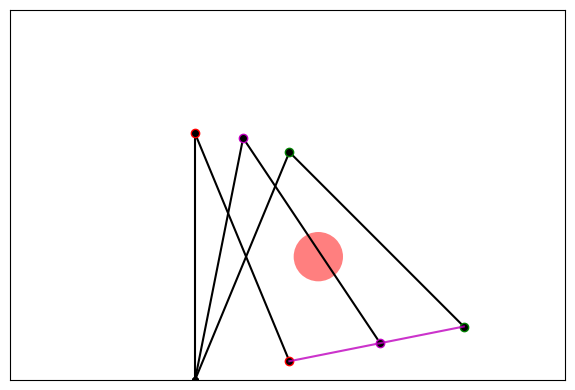

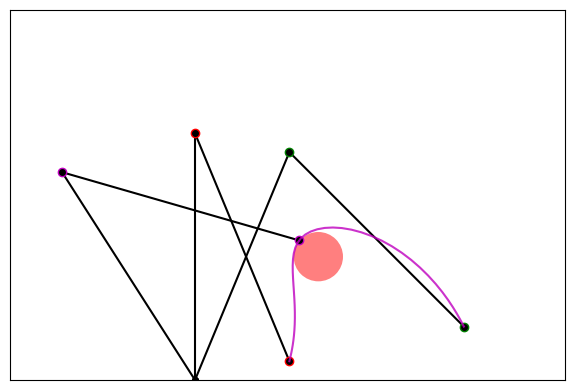

In [16]:
plotCartesianSpace(0)
plotCartesianSpace(20)

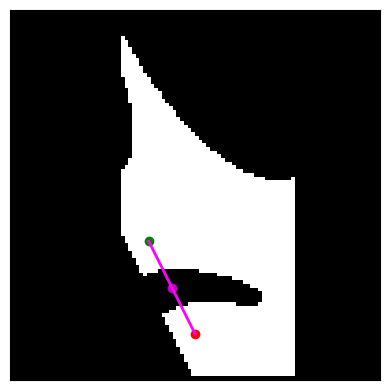

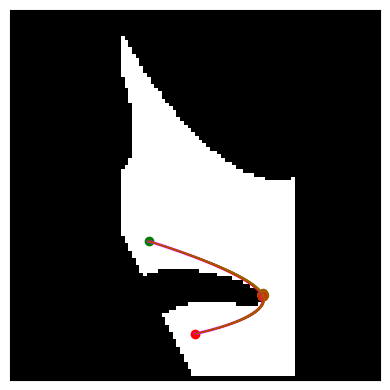

In [17]:
plotCSpace(0)
plotCSpace(20)

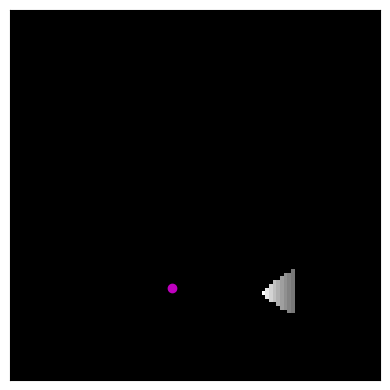

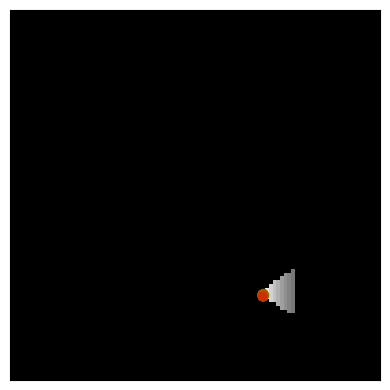

In [18]:
plotOptSpace(0)
plotOptSpace(20)